In [1]:
# Build a batch script around 'inference.py'
# Function of importance
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os, argparse, random, math, datetime
import cv2
import skimage.exposure
from data import process_image_file

class Inference(object):
    def __init__(self, weightspath, metaname, ckptname, input_size=480, n_classes=3, top_percent=0.08,
                 in_tensorname='input_1:0', out_tensorname='norm_dense_2/Softmax:0',is_severity_model=False):
        """
        weightspath: the path to the directory holding the pretrained model
        metaname: Name of ckpt meta file
        ckptname: Name of model ckpts
        imagepath: path to the image to run through the model
        """
        self.weightspath = weightspath
        self.metaname=metaname
        self.ckptname = ckptname
        self.input_size = input_size
        self.n_classes = n_classes
        self.top_percent = top_percent
        self.in_tensorname = in_tensorname
        self.out_tensorname = out_tensorname
        self.is_severity_model = is_severity_model
    
    def visualise_graph(self):
        tf.compat.v1.disable_eager_execution()
        with tf.compat.v1.Session() as sess:
            saver = tf.compat.v1.train.import_meta_graph(os.path.join(self.weightspath, self.metaname))
            saver.restore(sess, os.path.join(self.weightspath, self.ckptname))
            graph = tf.compat.v1.get_default_graph()
            tensors = [t.name for op in graph.get_operations() for t in op.values()]
            for t in tensors:
                print(t)
    
    def execute(self, normal_path, pneumonia_path, covid_path, verbose=False, equaliseHistogram=False):
        # To remove TF Warnings
        tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
        tf.compat.v1.disable_eager_execution()
        
        if self.is_severity_model:
            # For COVIDNet CXR-S training with COVIDxSev level 1 and level 2 air space seveirty grading
            mapping = {'level2': 0, 'level1': 1}
            inv_mapping = {0: 'level2', 1: 'level1'}
        elif self.n_classes == 2:
            # For COVID-19 positive/negative detection
            mapping = {'negative': 0, 'positive': 1}
            inv_mapping = {0: 'negative', 1: 'positive'}
        elif self.n_classes == 3:
            # For detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia
            mapping = {'normal': 0, 'pneumonia': 1, 'COVID-19': 2}
            inv_mapping = {0: 'normal', 1: 'pneumonia', 2: 'COVID-19'}
        else:
            raise Exception('''COVID-Net currently only supports 2 class COVID-19 positive/negative detection
                or 3 class detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia''')
        
        # Tensorflow
        mapping_keys = list(mapping.keys())
        with tf.compat.v1.Session() as sess:
            saver = tf.compat.v1.train.import_meta_graph(os.path.join(self.weightspath, self.metaname))
            saver.restore(sess, os.path.join(self.weightspath, self.ckptname))
            graph = tf.compat.v1.get_default_graph()

            image_tensor = graph.get_tensor_by_name(self.in_tensorname)
            pred_tensor = graph.get_tensor_by_name(self.out_tensorname)
            
            # Images to be processed are input here
            #if os.path.isdir(imagepath_or_directory):
            #    imagepaths_list = self.imagepaths(imagepath_or_directory)
            #else:
            #    imagepaths_list = [imagepath_or_directory]
            imagepaths_list, labels = self.images_and_labels(self.n_classes, normal_path, pneumonia_path, covid_path)
            # Predictions
            iters = 0
            preds_list = []
            for imagepath in imagepaths_list:
                iters +=1
                x = process_image_file(imagepath, self.top_percent, self.input_size) # images are read as 3-channel images
                # Grayscale image has the SAME values in ALL 3 channels
                if equaliseHistogram:
                    x = self.CV2_HistogramEqualisation(x)
                #if iters ==1:
                #    plt.imshow(x, cmap='gray')
                #    break
                x = x.astype('float32') / 255.0
                pred = sess.run(pred_tensor, feed_dict={image_tensor: np.expand_dims(x, axis=0)})
                preds_list.append(pred[0])
                if verbose:
                    print('Prediction: {}'.format(inv_mapping[pred.argmax(axis=1)[0]]))
                    print('Confidence')
                    print(' '.join('{}: {:.3f}'.format(cls.capitalize(), pred[0][i]) for cls, i in mapping.items()))
            preds_list = np.vstack(preds_list)
        return preds_list, labels
    
    ## Set up imagepaths
    def imagepaths(self, image_directory):
        path_list = []
        for root, dirs, files in os.walk(directory):
            for name in files:
                if '.png' in name:
                    path_list.append(os.path.join(root, name))
        return path_list
    
    def images_and_labels(self, n_classes, normal_path, pneumonia_path=None, covid_path=None):
        image_names=[]
        labels=[]
        if n_classes == 2:
            # Non-COVID and COVID
            label_normal=0
            label_pneumonia=0
            label_covid=1
        elif n_classes == 3:
            label_normal=0
            label_pneumonia=1
            label_covid=2
            
        if normal_path is not None:
            normalDir = os.listdir(normal_path)
            for allDir in normalDir:
                normal_image_name = os.path.join(normal_path, allDir)
                image_names.append(normal_image_name)
                label=label_normal
                labels.append(label)
        if pneumonia_path is not None:
            pneumoniaDir = os.listdir(pneumonia_path)
            for allDir in pneumoniaDir:
                pneumonia_image_name = os.path.join(pneumonia_path, allDir)
                image_names.append(pneumonia_image_name)
                label=label_pneumonia
                labels.append(label)
        
        if covid_path is not None:
            covidDir = os.listdir(covid_path)
            for allDir in covidDir:
                covid_image_name = os.path.join(covid_path, allDir)
                image_names.append(covid_image_name)
                label = label_covid
                labels.append(label)
        
        package=list(zip(image_names,labels))
        random.shuffle(package)
        image_names[:],labels[:]=zip(*package)
        return image_names, labels
    
    ## CUSTOM IMAGE PROCESSING
    def CV2_HistogramEqualisation(self, img):
        # 3-channel grayscale image to 1-channel grayscale image
        grayimg = img[:,:,0]
        grayimg = cv2.equalizeHist(grayimg) # EqualizeHist only works on 1-channel images
        rgbimg = np.stack([grayimg,grayimg,grayimg],axis=-1) # back to RGB
        return rgbimg
    
    def reset_graph(self):
        tf.compat.v1.reset_default_graph()
    def visualise_image(self, imagepath):
        x = process_image_file(imagepath, self.top_percent, self.input_size)
        print("Image size: " + str(x.shape))
        plt.imshow(x)
        return
    

print('**DISCLAIMER**')
print('Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.')

**DISCLAIMER**
Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.


In [2]:
inf_3class = Inference(weightspath="CXR4-A/", metaname="model.meta", ckptname="model-18540", n_classes=3,
                in_tensorname='input_1:0', out_tensorname='norm_dense_1/Softmax:0')

inf_2class = Inference(weightspath="CXR2_202103/", metaname="model.meta", ckptname="model", n_classes=2,
                in_tensorname='input_1:0', out_tensorname='norm_dense_2/Softmax:0')

dataset_normal={"NoSup":"D:/data/JSRT/JSRT/",# images are NOT histogram-equalized
                "Gusarev":"../Deep-Learning-Models-for-bone-suppression-in-chest-radiographs/bone_suppressed/JSRT_all_v5_HQ_nonEqualised_noInputHistEq_177-20-20/",
                "Rajaraman":"../Rajaraman_ResNet_BS/bone_suppressed/JSRT_all_v2_HQ_notEqualised_inputsNotEqualised_177-20-20/"}
dataset_pneumonia={"NoSup":None, 
                   "Gusarev":None, 
                   "Rajaraman":None}
dataset_covid={"NoSup":"D:/data/QEH_COVID19_DATASET/QEH_Earliest_CXR_per_patient/all/",# images are NOT histogram-equalized
                "Gusarev":"../Deep-Learning-Models-for-bone-suppression-in-chest-radiographs/bone_suppressed/QEH_onePerPatient_all_v5_HQ_nonEqualised_noInputHistEq_177-20-20/",
                "Rajaraman":"../Rajaraman_ResNet_BS/bone_suppressed/QEH_onePerPatient_all_v2_HQ_notEqualised_inputsNotEqualised_177-20-20/"}


In [3]:
preds = {"NoSup":[], "Gusarev":[], "Rajaraman":[]}
true_labels = {"NoSup":[], "Gusarev":[], "Rajaraman":[]}
for key in preds.keys():
    print("Starting {}".format(key))
    preds[key], true_labels[key] = inf_2class.execute(normal_path=dataset_normal[key],
                                                      pneumonia_path=dataset_pneumonia[key],
                                                      covid_path=dataset_covid[key],
                                        verbose=False, equaliseHistogram=False)
    inf_2class.reset_graph()
print("Completed.")


Starting NoSup
Starting Gusarev
Starting Rajaraman
Completed.


Confusion Matrix:
[[236   5]
 [224 300]]
overall acc: 70.07%


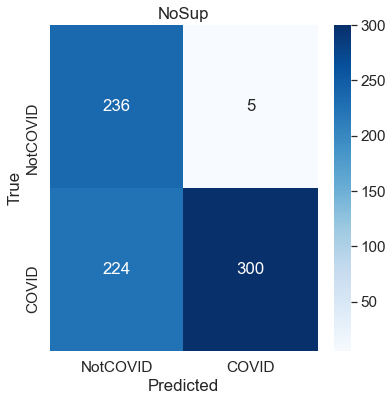

Confusion Matrix:
[[234   7]
 [184 340]]
overall acc: 75.03%


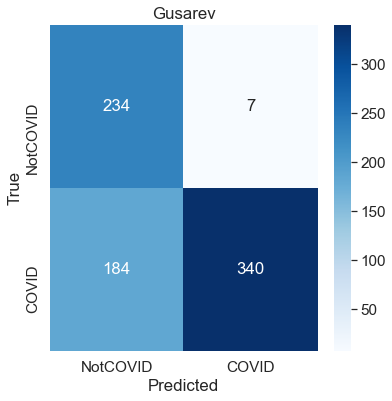

T-score Gusarev: 2.208404215791998
Confusion Matrix:
[[235   6]
 [185 339]]
overall acc: 75.03%


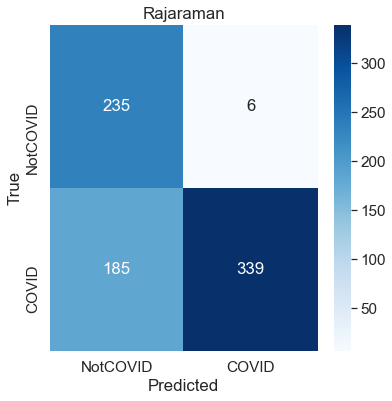

T-score Rajaraman: 2.063093544762575


In [22]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns
sns.set(font_scale=1.4)
def prediction_outputs(preds, true_labels=None, n_class = 2, title="", save_file=None):
    if true_labels is not None:
        preds_closest_ints = preds.argmax(axis=1)
        idx = preds_closest_ints == true_labels
        
        CM = confusion_matrix(true_labels, preds_closest_ints)
        print("Confusion Matrix:")
        print(CM)
        fig = plt.figure(figsize=(6,6))
        ax = plt.axes()
        sns.heatmap(CM, annot=True, 
                    fmt='d', cmap='Blues', 
                    xticklabels=("NotCOVID","COVID"),yticklabels=("NotCOVID","COVID"))
        ax.set(title=title, xlabel="Predicted", ylabel="True")
        if save_file is not None:
            plt.savefig(fname=save_file)
        
        num_classes = []
        if n_class == 2:
            num_classes.append(CM[0][0] + CM[0][1])
            num_classes.append(CM[1][0] + CM[1][1])
            overacc =(CM[0][0]+CM[1][1])/ (num_classes[0]+num_classes[1])
        if n_class == 3:
            overacc =(CM[0][0]+CM[1][1]+CM[2][2])/ (num_classes[0]+num_classes[1]+num_classes[2])
        print('overall acc: {acc:.2f}%'.format(acc=overacc*100))
        plt.show()
        return CM
    else:
        if n_class ==2:
            idx_nonCovid = preds[:,0] > preds[:,1]
            idx_Covid =  preds[:,0] <= preds[:,1]
            print("Proportion classed as non-COVID: " +str(np.sum(idx_nonCovid)/len(idx_nonCovid)))
            print("Proportion classed as COVID: " +str(np.sum(idx_Covid)/len(idx_Covid)))
        if n_class ==3:
            # 3 class
            idx_normal = np.logical_and( preds[:,0] > preds[:,1] , preds[:,0] > preds[:,2])
            idx_pneumonia = np.logical_and( preds[:,1] > preds[:,0] , preds[:,1] > preds[:,2])
            idx_COVID = np.logical_and( preds[:,2] > preds[:,1] , preds[:,2] > preds[:,0])

            print("Proportion classed as normal: " +str(np.sum(idx_normal)/len(idx_normal)))
            print("Proportion classed as pneumonia: " +str(np.sum(idx_pneumonia)/len(idx_pneumonia)))
            print("Proportion classed as COVID: " +str(np.sum(idx_COVID)/len(idx_COVID)))

def paired_t_test(array1, array2):
    array1 = array1.argmax(axis=1)
    array2 = array2.argmax(axis=1)
    
    x_diff = array1 - array2
    s_diff = np.std(x_diff)
    x_diff_mean = np.mean(x_diff)
    s_x = s_diff/np.sqrt(len(x_diff))
    
    t_score = np.abs(x_diff_mean/s_x)
    return t_score


for counter, status in enumerate(["NoSup","Gusarev","Rajaraman"]):
    prediction_outputs(preds[status], true_labels[status] , 2, title=status, save_file=status+".png")
    if counter > 0:
        print("T-score {}: {}".format(status,paired_t_test(preds["NoSup"], preds[status])))
    

In [7]:
STOP
"""preds1 = inf.execute(non_suppressed_directory_HK , verbose=False, equaliseHistogram=True)
inf.reset_graph()
preds2 = inf.execute(suppressed_Rajaraman_HK , verbose=False, equaliseHistogram=False)
inf.reset_graph()
"""
idx_COVID1 = np.logical_and( preds1[:,2] > preds1[:,1] , preds1[:,2] > preds1[:,0])
print(idx_COVID1)
idx_COVID2 = np.logical_and( preds2[:,2] > preds2[:,1] , preds2[:,2] > preds2[:,0])

NameError: name 'STOP' is not defined